In [2]:
import pandas as pd
import numpy as np

In [ ]:
weather_df = pd.read_csv('./data/asos.txt')

In [ ]:
weather_df.head()

In [ ]:
weather_df.rename({'valid':'datetime'},axis=1,inplace=True)

In [ ]:
# Let 'GW' denote Good Weather (aka normal weather)
weather_df['wxcodes'] = weather_df.wxcodes.replace(np.NaN, 'GW')
np.unique(weather_df.wxcodes)

In [ ]:
# intense rain, intense snow, intense thunderstorm, intense hail, rain, snow, thuderstorm, hail
def is_intense_rain(s):
    if '+' in s or '-' in s:
        if 'RA' in s:
            return 1
    return 0

def is_intense_snow(s):
    if '+' in s or '-' in s:
        if 'SN' in s:
            return 1
    return 0

def is_rain(s):
    if '+' not in s or '-' not in s:    
        if 'RA' in s:
            return 1
    return 0

def is_snow(s):
    if '+' not in s or '-' not in s:    
        if 'SN' in s:
            return 1
    return 0

In [ ]:
weather_df['heavy_snow'] = weather_df['wxcodes'].apply(lambda x: is_intense_snow(x))
weather_df['snow'] = weather_df['wxcodes'].apply(lambda x: is_snow(x))
weather_df['heavy_rain'] = weather_df['wxcodes'].apply(lambda x: is_intense_rain(x))
weather_df['rain'] = weather_df['wxcodes'].apply(lambda x: is_rain(x))

In [ ]:
weather_df['datetime'] = pd.to_datetime(weather_df.datetime).dt.round('H')

In [ ]:
# Drop rows with missing temperatures
missing_weather = weather_df.loc[weather_df.tmpc.isna()].index
weather_df.drop(missing_weather, inplace=True)

In [ ]:
# Impute missing ice_accretion with 0, as it means they did not snow that day
ia = [f'ice_accretion_{i}hr' for i in ['1','3','6']]
for i in ia:
    weather_df[i] = weather_df[i].astype(float).fillna(0)

In [ ]:
weather_df.dtypes

In [ ]:
weather_df = weather_df.groupby('datetime').agg({'tmpc': np.mean, 'heavy_snow': np.sum, 'snow': np.sum, 'heavy_rain': np.sum, 'rain': np.sum}).reset_index()

In [ ]:
weather_df.to_csv('./data/weather.csv')
del weather_df

Dataset ETL:
- Drop columns deemed irrelevant (according to the sample dataset, we found these to be non-interesting for the analysis)
- Convert require columns to datetime
- Add a trip duration column, which will be stored in minutes
- No need to worry about invalid long/lat as the data set is now in valid taxi zones

In [3]:
output = pd.DataFrame()

for i in range(1, 13):
    print(f"Processing {i}")
    if i < 10:
        df = pd.read_csv(f"./data/yellow_tripdata_2018-0{i}.csv")

    else:
        df = pd.read_csv(f"./data/yellow_tripdata_2018-{i}.csv")
    
    # Ensure all values fall within the defined values in the Dictionary specified
    df['RatecodeID'] = df['RatecodeID'].apply(lambda x: int(x) if x in range(1, 7) else np.NaN)
    df['payment_type'] = df['payment_type'].apply(lambda x: int(x) if x in range(1, 7) else np.NaN)
    
    # Convert to datetime
    df['PUdatetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
    df['DOdatetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
    
    # Add trip duration by seconds
    df['trip_duration'] = df['DOdatetime'] - df['PUdatetime']
    df['trip_duration'] = df['trip_duration'].dt.seconds // 60 # round to the nearest minute so we preserve int

    df.drop(['tpep_pickup_datetime','tpep_dropoff_datetime'],axis=1,inplace=True)
    
    # Refer to EDA_sample for reasoning behind this
    invalid_vals = df[(df[['trip_duration','trip_distance']] <= 0).any(axis=1)].index
    df = df.drop(axis=0, index=invalid_vals)
    df = df.dropna()
    
    """
    TAXI 2 - Datetime, Duration, Location, Distance
    """
    df = df[['PUdatetime','DOdatetime','PULocationID','trip_duration','trip_distance']]

    output = pd.concat([output, df])
    
    del df

output.reset_index().to_feather('./data/2018taxi_durations.feather')

Processing 1
Processing 2
Processing 3
Processing 4
Processing 5
Processing 6
Processing 7
Processing 8
Processing 9
Processing 10
Processing 11
Processing 12


In [5]:
output = pd.DataFrame()

for i in range(1, 13):
    print(f"Processing {i}")
    if i < 10:
        df = pd.read_csv(f"./data/yellow_tripdata_2018-0{i}.csv")

    else:
        df = pd.read_csv(f"./data/yellow_tripdata_2018-{i}.csv")
    
    # Ensure all values fall within the defined values in the Dictionary specified
    df['RatecodeID'] = df['RatecodeID'].apply(lambda x: int(x) if x in range(1, 7) else np.NaN)
    df['payment_type'] = df['payment_type'].apply(lambda x: int(x) if x in range(1, 7) else np.NaN)
    
    # Convert to datetime
    df['PUdatetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
    df['DOdatetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
    
    # Add trip duration by seconds
    df['trip_duration'] = df['DOdatetime'] - df['PUdatetime']
    df['trip_duration'] = df['trip_duration'].dt.seconds // 60 # round to the nearest minute so we preserve int

    df.drop(['tpep_pickup_datetime','tpep_dropoff_datetime'],axis=1,inplace=True)
    
    # Refer to EDA_sample for reasoning behind this
    invalid_vals = df[(df[['trip_duration','trip_distance']] <= 0).any(axis=1)].index
    df = df.drop(axis=0, index=invalid_vals)
    df = df.dropna()
    
    """
    TAXI 1 - Datetime, Duration, Fare, Tip USING ONLY CREDIT CARD TO REMOVE OUTLIERS
    - This is because cash is uncertain (i.e some recorded, some not)
    """
    df = df.loc[df['payment_type'] == 1][['PUdatetime','DOdatetime','PULocationID','fare_amount','tip_amount']]

    output = pd.concat([output, df])
    
    del df

output.reset_index().to_feather('./data/2018taxi_fares.feather')

Processing 1
Processing 2
Processing 3
Processing 4
Processing 5
Processing 6
Processing 7
Processing 8
Processing 9
Processing 10
Processing 11
Processing 12


In [4]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv(f"./data/yellow_tripdata_2018-01.csv")

In [5]:
df['RatecodeID'] = df['RatecodeID'].apply(lambda x: int(x) if x in range(1, 7) else np.NaN)
df['payment_type'] = df['payment_type'].apply(lambda x: int(x) if x in range(1, 7) else np.NaN)

# Convert to datetime
df['PUdatetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['DOdatetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

# Add trip duration by seconds
df['trip_duration'] = df['DOdatetime'] - df['PUdatetime']
df['trip_duration'] = df['trip_duration'].dt.seconds // 60 # round to the nearest minute so we preserve int

df.drop(['tpep_pickup_datetime','tpep_dropoff_datetime'],axis=1,inplace=True)

# Refer to EDA_sample for reasoning behind this
invalid_vals = df[(df[['trip_duration','trip_distance']] <= 0).any(axis=1)].index
df = df.drop(axis=0, index=invalid_vals)
df = df.dropna()

In [10]:
df['count'] = 1

In [11]:
df.columns

Index(['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID',
       'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type',
       'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'PUdatetime', 'DOdatetime',
       'trip_duration', 'count'],
      dtype='object')

In [13]:
temp = df.groupby('PULocationID').agg({'trip_duration': 'mean',
                                       'fare_amount': 'mean',
                                       'tip_amount': 'mean',
                                       'count': 'sum'
}).reset_index()

In [17]:
temp.head()

,PULocationID,trip_duration,fare_amount,tip_amount,count
0,1,15.683333,56.770333,6.011000,60
1,2,30.500000,30.375000,4.262500,4
2,3,14.361111,16.055556,0.758056,36
3,4,14.087430,11.245184,1.475331,19467
4,6,17.521739,19.043478,3.363478,23


In [19]:
sf = gpd.read_file("./data/taxi_zones/taxi_zones.shp")
# Drop these columns since they are preserved in the zone_lookup.csv 
sf.drop(['OBJECTID','Shape_Leng','Shape_Area','zone','borough'],axis=1,inplace=True)
# Convert to long/lat 
sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

In [21]:
temp = pd.merge(temp, sf, left_on='PULocationID', right_on='LocationID')

In [36]:
temp['yongsee'] = np.log((temp['fare_amount'] + temp['tip_amount']) / temp['trip_duration'] + 0.001)

In [37]:
temp.head()

,PULocationID,trip_duration,fare_amount,tip_amount,count,LocationID,geometry,yongsee
0,1,15.683333,56.770333,6.011000,60,1,POLYGON ((-74.18445299999996 40.69499599999989...,1.387309
1,2,30.500000,30.375000,4.262500,4,2,(POLYGON ((-73.82337597260663 40.6389870471767...,0.128090
2,3,14.361111,16.055556,0.758056,36,3,"POLYGON ((-73.84792614099985 40.8713422339999,...",0.158519
3,4,14.087430,11.245184,1.475331,19467,4,POLYGON ((-73.97177410965318 40.72582128133705...,-0.100960
4,6,17.521739,19.043478,3.363478,23,6,POLYGON ((-74.06367318899999 40.60219816599994...,0.246711


In [38]:
import matplotlib.pyplot as plt

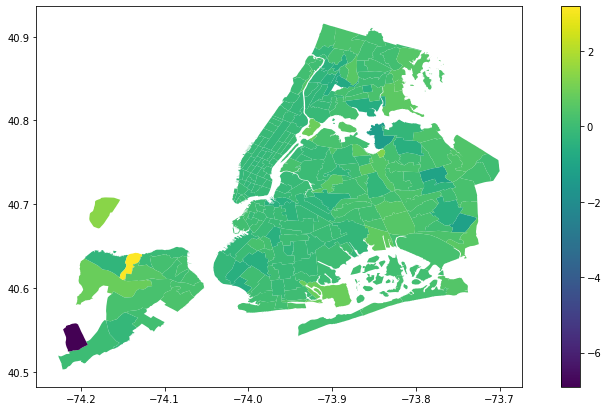

In [39]:
fig, ax = fig, ax = plt.subplots(1, 1, figsize=(14,7))

gpd.GeoDataFrame(temp).plot(column='yongsee', ax=ax, legend=True)

In [15]:
((temp['fare_amount'] + temp['tip_amount']) / temp['trip_duration']) * (temp['count'] / temp['count'].sum())

0      2.768850e-05
1      5.236761e-07
2      4.858828e-06
3      2.026413e-03
4      3.390701e-06
           ...     
252    4.724944e-03
253    1.198086e-02
254    1.821927e-02
255    1.588560e-02
256    3.021501e-04
Length: 257, dtype: float64